This second practical work, on motion estimation, deals with parametric motion estimation. You have to reuse some of the functions you implemented during the first practical work.

You are asked to complete the different algorithms and to try it. Also, please answer to the theoretical questions, in the notebook.

In [84]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import cv2
from scipy.ndimage import gaussian_filter
from scipy.interpolate import griddata
from scipy.signal import convolve2d
from cv2 import copyMakeBorder,BORDER_REPLICATE

In [85]:
def displayMVF(I,mvf,subsamp):
    
    row,col = np.shape(I)
    
    # Subsample dense MVF 
    vectRow = mvf[0:row:subsamp,0:col:subsamp,0]
    vectCol = mvf[0:row:subsamp,0:col:subsamp,1]
    
    # Determine vector origins
    X,Y = np.meshgrid(np.arange(0,col,subsamp),np.arange(0,row,subsamp))
    X = X + np.floor(subsamp/2.)
    Y = Y + np.floor(subsamp/2.)
    
    # Show image
    plt.figure()
    plt.imshow(I,cmap='gray')

    plt.quiver(X, Y, vectCol,-vectRow)

    
    return

#%%
def initVector(ref,cur):
    """
    Performs an initialization for the first regularizers

    Parameters
    ----------
    ref : np.array
        Reference image.
    cur : np.array
        Reference image.

    Returns
    -------
    pV : np.array (vector of size 2)
        Regularizer for displacement.

    """
    
    
    step = 8
    cont = 4*step
    
    REF = gaussian_filter(ref,1.) # Unclear how to set sigma
    CUR = gaussian_filter(cur,1.)
    
    CUR = CUR[cont+1:(np.shape(CUR)[0]-cont):step,cont+1:(np.shape(CUR)[1]-cont):step]
    SSDMIN = np.inf
    
    pV=np.zeros(2)
    
    for globR in range(-cont,cont):
        for globC in range(-cont,cont):
            RR = REF[cont+1-globR:(cont-globR+np.shape(CUR)[0]*step):step, cont+1-globC:(cont-globC+np.shape(CUR)[1]*step):step]
            SSD = np.sum((RR-CUR)**2)
            
            if SSD<SSDMIN:
                SSDMIN=SSD
                pV[0]=globR
                pV[1]=globC
                
                
    return pV

#%%
def computePredictor(r,c,brow,bcol,mvf,ref,cur):
    """
    compute predictor gives the median of the mvf of the blocks :
        - to the left of the current block
        - above the current block
        - upper left of the current block
        
    If such blocks do not exist due to the border effects, they are not taken into account.

    Parameters
    ----------
    See usage in the me_ssd function

    Returns
    -------
    pV : Median of the mvf of the neighboor blocks

    """
    if r < brow and c < bcol:
        pV = initVector(ref,cur)
        
    elif r < brow: # First row
        pV = mvf[r,c-bcol,:]
        
    elif c < bcol: # First column
        pV = mvf[r-brow,c,:]
        
    else: # Inside
        if c >= np.shape(mvf)[1]-bcol: # Last column
            vC = mvf[r-brow,c-bcol,:]
        
        else: # Not the last column
            vC = mvf[r-brow,c+bcol,:]
            
        vA = mvf[r,c-bcol,:]
        vB = mvf[r-brow,c,:]

        temp = np.array([vA, vB, vC]).T

        pV = np.median(temp,axis = 1)
        
    pV = pV.ravel()
    
    return pV


#%%
def me_ssd(cur, ref, brow, bcol, search, lamb=0):
    """
    ME BMA full search Motion estimation
    mvf, prediction = me_ssd(cur, ref, brow, bcol, search);

    A regularization constraint can be used
    mvf = me(cur, ref, brow, bcol, search, lambda);
    In this case the function minimize SAD(v)+lambda*error(v)
    where error(v) is the difference between the candidate vector v and the
    median of its avalaible neighbors.
 
    Code inspired from the one of Marco Cagnazzo


    Parameters
    ----------
    cur : numpy array
        Current (i.e. second) frame of the video.
    ref : numpy array
        Previous (i.e. first) frame of the video.
    brow : int
        Number of rows in each block.
    bcol : int
        Number of rows in each block.
    search : int
        Search radius
    lamb : double
        Regularization parameter

    Returns
    -------
    mvf : TYPE
        DESCRIPTION.
    prediction : TYPE
        DESCRIPTION.

    """
    
    extension = search
    
    ref_extended = cv2.copyMakeBorder(ref, extension, extension, extension, extension, cv2.BORDER_REPLICATE) # To avoid border effect
    
    prediction = np.zeros(np.shape(cur));
    lamb *= brow*bcol;
    
    mvf = np.zeros((np.shape(cur)[0],np.shape(cur)[1],2))
    cur_col = np.shape(cur)[1]
    cur_row = np.shape(cur)[0]
    # Non-regularized search
    if lamb == 0.:
        for c in range(0,cur_col,bcol) : # for each block in the current image, find the best corresponding block in the reference image
            for r in range(0,cur_row,brow) :
                # current block selection
                B = cur[r : r + brow,c : c + bcol] # Block

                # Initialization:
                
                costMin = np.inf
                # the best one is that the block still not moving
                Rbest = [0,0]
                
                # Loop on candidate displacement vectors
                for dcol in range(-search,search): # dcol = candidate displacement vector over the columns
                    for drow in range(-search,search):# rcol = candidate displacement vector over the rows
                        
                        block_extracted = ref_extended[search+r+drow:search+r+drow+brow,search+c+dcol:search+c+dcol+bcol]
                        block_error = np.linalg.norm(B-block_extracted)**2
                        if block_error<costMin: # Save the results if they are better than the previous ones
                            costMin = block_error
                            Rbest = [drow,dcol]
                # so we search (y,x,2) so if we call the (y,x,:) these are the row and column displacment for instance (3,2,:) = [-2,7] so we need to move the
                # pixel (3,2) 2 pixel down and 7 pixel right since it corresponds to y and x organization.
                mvf[r:r+brow, c:c+bcol, 0] = Rbest[0] # Once the loop is over, save the best row displacement field
                mvf[r:r+brow, c:c+bcol, 1] = Rbest[1] # Once the loop is over, save the best column displacement field
                # the need behind adding search parameter is that we use the expanded image which is already expanded by the size of the extention which is 16 
                prediction[r:r+brow,c:c+bcol]= ref_extended[search+Rbest[0]+r:search+Rbest[0]+r+brow, search+Rbest[1]+c:search+Rbest[1]+c+bcol]
                
    else: # Regularized search
        for c in range(0,cur_col,bcol): # for each block in the current image, find the best corresponding block in the reference image
            for r in range(0,cur_row,brow):
                # current block selection
                B = cur[r:r+brow,c:c+bcol] # Block

                # Initializations          
                
                costMin = np.inf
                # here the intial value or displacement that we can put is [0,0] assuming that the blcok did not move away
                Rbest = [0,0]
                
                # Neighbours : pV is the regularization vector. The regularizer must be such that the estimated displacement is not too far away from pV
                pV = computePredictor(r,c,brow,bcol,mvf,ref,cur)
                
                # Loop on candidate vectors
                for dcol in range(-search,search): # dcol = candidate displacement vector over the columns
                    for drow in range(-search,search):# rcol = candidate displacement vector over the rows
                        block_extracted = ref_extended[search+r+drow:search+r+drow+brow,search+c+dcol:search+c+dcol+bcol]
                        # as mentioned in the course the reglarized term is calculated as a diffrence between the current candidate block and the median of the neighboring pixels
                        pos_cur = [drow,dcol]
                        regularized_term_to_be_calculated = lamb*(np.linalg.norm(pV-pos_cur))
                        cost = np.linalg.norm(B-block_extracted)**2 + regularized_term_to_be_calculated # here, encore the REGULARIZED cost function
                        if cost<costMin: # Save the results if they are better than the previous ones
                            costMin=cost
                            # save the row and column displacement for each pixel 
                            Rbest=[drow,dcol]
                
                
                
                mvf[r:r+brow,c:c+bcol,0]=Rbest[0]  # Once the loop is over, save the best row displacement field
                mvf[r:r+brow,c:c+bcol,1]= Rbest[1] # Once the loop is over, save the best column displacement field
                prediction[r:r+brow,c:c+bcol]=ref_extended[search+r+drow:r+drow+search+brow,search+c+dcol:search+c+dcol+bcol]
                
                
    #mvf = mvf # For compatibility with standards
    return mvf, prediction

In [87]:
def computePredictor(r,c,brow,bcol,mvf,ref,cur):
    """
    compute predictor gives the median of the mvf of the blocks :
        - to the left of the current block
        - above the current block
        - upper left of the current block
        
    If such blocks do not exist due to the border effects, they are not taken into account.

    Parameters
    ----------
    See usage in the me_ssd function

    Returns
    -------
    pV : Median of the mvf of the neighboor blocks

    """
    if r < brow and c < bcol:
        pV = initVector(ref,cur)
        
    elif r < brow: # First row
        pV = mvf[r,c-bcol,:]
        
    elif c < bcol: # First column
        pV = mvf[r-brow,c,:]
        
    else: # Inside
        if c >= np.shape(mvf)[1]-bcol: # Last column
            vC = mvf[r-brow,c-bcol,:]
        
        else: # Not the last column
            vC = mvf[r-brow,c+bcol,:]
            
        vA = mvf[r,c-bcol,:]
        vB = mvf[r-brow,c,:]

        temp = np.array([vA, vB, vC]).T

        pV = np.median(temp,axis = 1)
        
    pV = pV.ravel()
    
    return pV

#%%
def initVector(ref,cur):
    """
    Performs an initialization for the first regularizers

    Parameters
    ----------
    ref : np.array
        Reference image.
    cur : np.array
        Reference image.

    Returns
    -------
    pV : np.array (vector of size 2)
        Regularizer for displacement.

    """
    
    
    step = 8
    cont = 4*step
    
    REF = gaussian_filter(ref,1.) # Unclear how to set sigma
    CUR = gaussian_filter(cur,1.)
    
    CUR = CUR[cont+1:(np.shape(CUR)[0]-cont):step,cont+1:(np.shape(CUR)[1]-cont):step]
    SSDMIN = np.inf
    
    pV=np.zeros(2)
    
    for globR in range(-cont,cont):
        for globC in range(-cont,cont):
            RR = REF[cont+1-globR:(cont-globR+np.shape(CUR)[0]*step):step, cont+1-globC:(cont-globC+np.shape(CUR)[1]*step):step]
            SSD = np.sum((RR-CUR)**2)
            
            if SSD<SSDMIN:
                SSDMIN=SSD
                pV[0]=globR
                pV[1]=globC
                
                
    return pV
#%%
def me_sad(cur, ref, brow, bcol, search, lamb=0):
    """
    ME BMA full search Motion estimation
    mvf, prediction = me_ssd(cur, ref, brow, bcol, search);

    A regularization constraint can be used
    mvf = me(cur, ref, brow, bcol, search, lambda);
    In this case the function minimize SAD(v)+lambda*error(v)
    where error(v) is the difference between the candidate vector v and the
    median of its avalaible neighbors.
 
    Code inspired from the one of Marco Cagnazzo


    Parameters
    ----------
    cur : numpy array
        Current (i.e. second) frame of the video.
    ref : numpy array
        Previous (i.e. first) frame of the video.
    brow : int
        Number of rows in each block.
    bcol : int
        Number of rows in each block.
    search : int
        Search radius
    lamb : double
        Regularization parameter

    Returns
    -------
    mvf : TYPE
        DESCRIPTION.
    prediction : TYPE
        DESCRIPTION.

    """
    
    extension = search
    
    ref_extended = cv2.copyMakeBorder(ref, extension, extension, extension, extension, cv2.BORDER_REPLICATE)
    
    prediction = np.zeros(np.shape(cur));
    lamb *= brow*bcol;
    
    mvf = np.zeros((np.shape(cur)[0],np.shape(cur)[1],2))
    cur_col = np.shape(cur)[1]
    cur_row = np.shape(cur)[0]
    # Non-regularized search
    if lamb == 0.:
        for c in range(0,cur_col,bcol) : # for each block in the current image, find the best corresponding block in the reference image
            for r in range(0,cur_row,brow) :
                # current block selection
                B = cur[r : r + brow,c : c + bcol] # Block

                # Initialization:
                
                costMin = np.inf
                # the best one is that the block still not moving
                Rbest = [0,0]
                
                # Loop on candidate displacement vectors
                for dcol in range(-search,search): # dcol = candidate displacement vector over the columns
                    for drow in range(-search,search):# rcol = candidate displacement vector over the rows
                        
                        block_extracted = ref_extended[search+r+drow:search+r+drow+brow,search+c+dcol:search+c+dcol+bcol]
                        block_error = np.sum(np.abs(B-block_extracted))
                        
                        if block_error<costMin: # Save the results if they are better than the previous ones
                            costMin = block_error
                            Rbest = [drow,dcol]
                # so we search (y,x,2) so if we call the (y,x,:) these are the row and column displacment for instance (3,2,:) = (-2,7) so we need to move the
                # pixel (3,2) 2 pixel down and 7 pixel right since it corresponds to y and x organization.
                mvf[r:r+brow, c:c+bcol, 0] = Rbest[0] # Once the loop is over, save the best row displacement field
                mvf[r:r+brow, c:c+bcol, 1] = Rbest[1] # Once the loop is over, save the best column displacement field
                # the need behind adding search parameter is that we use the expanded image which is already expanded by the size of the extention which is 16 
                prediction[r:r+brow,c:c+bcol]= ref_extended[search+Rbest[0]+r:search+Rbest[0]+r+brow, search+Rbest[1]+c:search+Rbest[1]+c+bcol]
        

                
    else: # Regularized search
         for c in range(0,cur_col,bcol): # for each block in the current image, find the best corresponding block in the reference image
            for r in range(0,cur_row,brow):
                # current block selection
                B = cur[r:r+brow,c:c+bcol] # Block

                # Initializations          
                
                costMin = np.inf
                # here the intial value or displacement that we can put is [0,0] assuming that the blcok did not move away
                Rbest = [0,0]
                
                # Neighbours : pV is the regularization vector. The regularizer must be such that the estimated displacement is not too far away from pV
                pV = computePredictor(r,c,brow,bcol,mvf,ref,cur)
                
                # Loop on candidate vectors
                for dcol in range(-search,search): # dcol = candidate displacement vector over the columns
                    for drow in range(-search,search):# rcol = candidate displacement vector over the rows
                        
                        block_extracted = ref_extended[search+r+drow:search+r+drow+brow,search+c+dcol:search+c+dcol+bcol]
                        # as mentioned in the course the reglarized term is calculated as a diffrence between the current candidate block and the median of the neighboring pixels
                        

                        pos_cur = [drow,dcol]

                        # here it is obtained just by computing the norm of the difference of the candidate displacment and the median of the neighboring displacement.
                        regularized_term_to_be_calculated = lamb*(np.linalg.norm(pV-pos_cur))

                        cost = np.sum(np.abs(B-block_extracted)) + regularized_term_to_be_calculated # here, encore the REGULARIZED cost function
                        if cost<costMin: # Save the results if they are better than the previous ones
                            costMin=cost
                            # save the row and column displacement for each pixel 
                            Rbest=[drow,dcol]
                
                
                
                mvf[r:r+brow,c:c+bcol,0]=Rbest[0]  # Once the loop is over, save the best row displacement field
                mvf[r:r+brow,c:c+bcol,1]= Rbest[1] # Once the loop is over, save the best column displacement field
                prediction[r:r+brow,c:c+bcol]=ref_extended[search+r+drow:r+drow+search+brow,search+c+dcol:search+c+dcol+bcol]
                
                
    mvf = -mvf # For compatibility with standards
                            
    return mvf, prediction

# Parametric estimation
In this second practical work, we will work on parametric estimation, both using direct and indirect methods.
## I- Direct parametric estimation
## I-1 Theoretical questions

**Infinite signal**

Let $a: (n,m)\in \mathbb{Z}^2 \rightarrow \mathbb{R}$ be a bi-dimensional signal and $b(n,m)$ a signal of the same type.

Recall the expression of the 2D discrete time Fourier transform (DTFT).

Let us suppose that
$\exists c,d \in \mathbb{Z}^2: \forall n,m \in \mathbb{Z}^2,b(n,m) = a(n+c,m+d)$ (that is, $b$ is a translation of $a$). Compute the DTFT of $b$ as a function of the one of $a$ and of the displacement $(c,d)$.

Answer :

$$ \hat{b}(\nu_x, \nu_y) = \sum_{n=-\infty}^{\infty} \sum_{m=-\infty}^{\infty} b(n,m)e^{-2\pi*j(\nu_x n+\nu_y m)} $$

Substitute $ b(n,m) = a(n+c,m+d) $ :

$$ \hat{b}(\nu_x, \nu_y) = \sum_{n=-\infty}^{\infty} \sum_{m=-\infty}^{\infty} a(n+c,m+d)e^{-2\pi*j(\nu_x n+\nu_y m)} $$

Let $ n' = n+c $ and $ m' = m+d $. Then, $ n = n' - c $ and $ m = m' - d $ ,  and we can rewrite the sum as:

$$ \hat{b}(\nu_x, \nu_y) = \sum_{n'=-\infty}^{\infty} \sum_{m'=-\infty}^{\infty} a(n',m')e^{-2\pi*j(\nu_x (n'-c)+\nu_y (m'-d))} $$

Splitting the exponentials, we obtain:

$$ \hat{b}(\nu_x, \nu_y) = \sum_{n'=-\infty}^{\infty} \sum_{m'=-\infty}^{\infty} a(n',m')e^{-2\pi*j(\nu_x n' + \nu_y m')} \cdot e^{2\pi*j(\nu_x c+\nu_y d)} $$

the first part is the DTFT of a , and the second term which is $ e^{2\pi*j(\nu_x c+\nu_y d)} $ is a constant with respect to the summation variables, we can factor it out:

$$ \hat{b}(\nu_x, \nu_y) = \hat{a}(\nu_x, \nu_y) \cdot e^{2\pi*j(\nu_x c+\nu_y d)} $$

Therefore, the DTFT of $b(n,m)$ is equal to the DTFT of $ a(n,m) $ multiplied by $ e^{2\pi*j(\nu_x c+\nu_y d)} $.

This result shows how translation in the spatial domain corresponds to a phase shift in the frequency domain.

Show that the ratio between the DTFTs is:
$$
\frac{\hat{b}(\nu_x,\nu_y)}{\hat{a}(\nu_x,\nu_y)} = \exp(i2\pi (c\nu_x + d \nu_y))
$$

Answer :

look above it is answered ,in addition the process of demonstarting that is well-detailed.

**Finite signal**

Now, $a: (n,m) \in \{0,1,...,N-1\}^2 \rightarrow \mathbb{R}$ and $b(n,m)$ are both finite signals. In that case, we use the Discrete Fourier Transform (DFT) rather than the DTFT.

Recall the expression of the DFT.


$$\hat{A}(k_x, k_y) = \sum_{n=0}^{N-1} \sum_{m=0}^{N-1} a(n,m)e^{-\frac{2i\pi}{N}(k_x n + k_y m)}$$


Under which hypotheses is the ratio between $a$'s and $b$'s DFT a linear phase signal:
$$
\frac{\hat{A}(k_x,k_y)}{\hat{B}(k_x,k_y)} = \exp\left(\frac{2i\pi(ck_x + dk_y)}{N}\right)
$$

first demonstarting the formula :

 The DFT of $\hat{B}(n,m)$ can be expressed as:

$$ \hat{B}(k_x, k_y) = \sum_{n=0}^{N-1} \sum_{m=0}^{N-1} b(n,m)e^{-\frac{2i\pi}{N}(k_x n + k_y m)} $$

Substituting $b(n,m) = a(n+c, m+d)$:

$$ \hat{B}(k_x, k_y) = \sum_{n=0}^{N-1} \sum_{m=0}^{N-1} a(n+c,m+d)e^{-\frac{2i\pi}{N}(k_x n + k_y m)} $$

Applying the same process of above usinng variable changing to achieve the formula that we want to demonstarte 


$$
\frac{\hat{A}(k_x,k_y)}{\hat{B}(k_x,k_y)} = \exp\left(\frac{2i\pi(ck_x + dk_y)}{N}\right)
$$

the hypothesis that should be taken into consideration to acheive a linear phase ratio are : 

The ratio between a's and b's DFT becomes a linear phase signal under the hypothesis that $b(n, m) = a(n+c, m+d)$ is a spatial translation of $a(n, m)$ This relationship holds true when considering the discrete and finite nature of the signals, where c and d are integer shifts within the signal's dimensions. The linear phase signal's form, $\exp\left(\frac{2i\pi(ck_x + dk_y)}{N}\right)$, directly results from this spatial translation, highlighting the Fourier transform's characteristic response to spatial shifts within a discrete domain.

Moreever the DFT take into consideration the periodicity of the translated image this is crucial to avoid the problem of passing the boundaries of the signal, specifically the image as we are working on them.



## I-2 Practical part
First, start to work on the 'ball.mat' image. We will apply a translation to this image and try to estimate the parameter of the translation.

Try by either adding or not some noise into the image.

In [88]:
im_ball = loadmat('ball.mat')['im1']
im_ball = im_ball.astype('float')

im_lena = loadmat('lena.mat')['im1']
im_lena = im_lena.astype('float')

N_shape_ball, M_shape_ball = np.shape(im_ball)
N_shape_lena ,M_shape_lena = np.shape(im_lena)


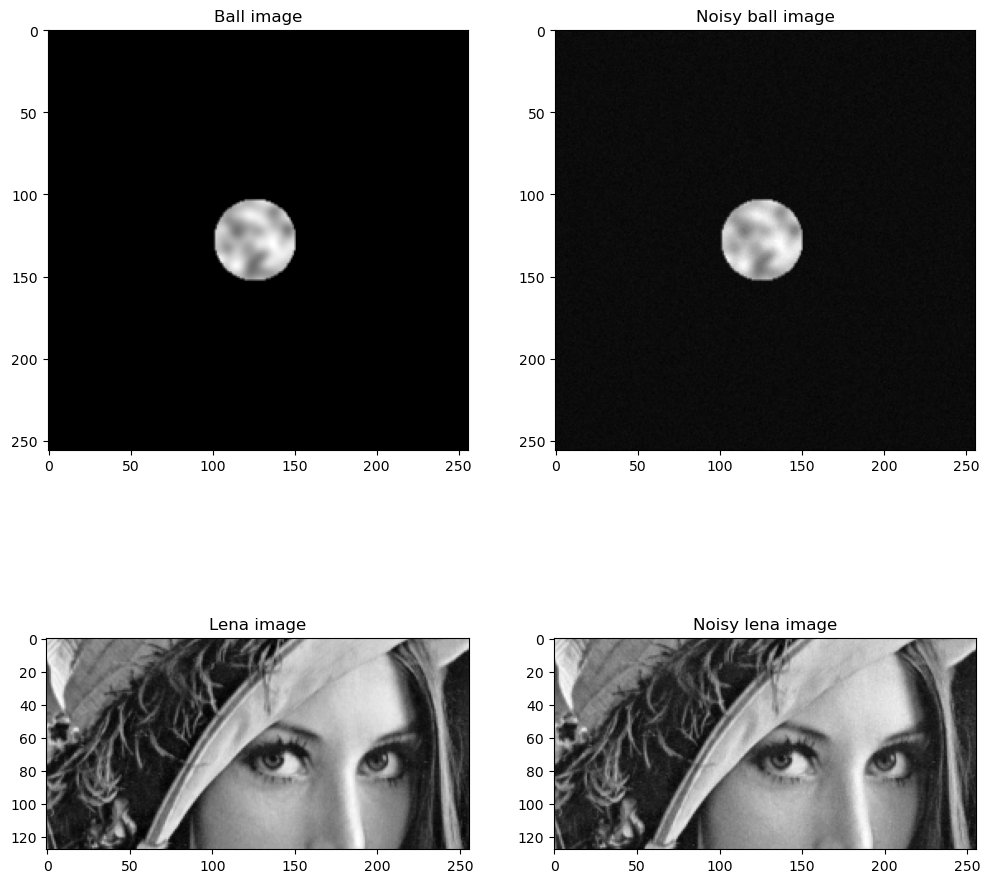

In [89]:
sigma = 2
gaussian_noise_ball = sigma*np.random.randn(N_shape_ball, M_shape_ball)#np.random.normal(10, sigma, im_ball.shape)
gaussian_noise_lena = sigma*np.random.randn(N_shape_lena, M_shape_lena)#np.random.normal(10, sigma, im_lena.shape)



im_ball_noisy = im_ball + gaussian_noise_ball
im_lena_noisy = im_lena + gaussian_noise_lena

plt.figure(figsize=(12,12))
plt.subplot(2, 2, 1)
plt.imshow(im_ball, cmap='gray')
plt.title('Ball image')

plt.subplot(2, 2, 2)
plt.imshow(im_ball_noisy, cmap='gray')
plt.title('Noisy ball image')

plt.subplot(2, 2, 3)
plt.imshow(im_lena, cmap='gray')
plt.title('Lena image')

plt.subplot(2, 2, 4)
plt.imshow(im_lena_noisy, cmap='gray')
plt.title('Noisy lena image')

plt.show()

In the following, we apply a translation to the image. To do that, use the applyAffineMotion function which is already pre-implemented.

In [90]:
def fracMc(ref,mvf,outofbound=20):
    
    [rows, cols] = np.shape(ref);
    
    
    
    mc_c, mc_r = np.meshgrid(np.arange(cols),np.arange(rows)) # Initial coordinates, used to infer the new coordinates
    
    mc_r_tmp = mc_r + mvf[:,:,0] # Row coordinates, after the movement
    mc_c_tmp = mc_c + mvf[:,:,1] # Column coordinates, after the movement
    
    extension = outofbound
    #ref = cv2.copyMakeBorder(ref, extension, extension, extension, extension, cv2.BORDER_REPLICATE)# Padded image
    ref = cv2.copyMakeBorder(ref, extension, extension, extension, extension, cv2.BORDER_REFLECT)# Padded image
    
    mc_r = mc_r_tmp + extension # Row coordinates, after the movement, in which we want to do the interpolation (in the padded image)
    mc_c = mc_c_tmp + extension # Column coordinates, after the movement, in which we want to do the interpolation (in the padded image)
    
    colMeshGrid, rowMeshGrid = np.meshgrid(np.arange(cols+2*extension),np.arange(rows+2*extension)) # Original coordinates, at which we know the data points
    
    
    # Put the input coordinates into the form of an array, to mach scipy format
    points = np.zeros((np.shape(ref)[0]*np.shape(ref)[1],2))
    points[:,0] = colMeshGrid.reshape(np.shape(ref)[0]*np.shape(ref)[1])
    points[:,1] = rowMeshGrid.reshape(np.shape(ref)[0]*np.shape(ref)[1])
    
    values = ref.reshape(np.shape(ref)[0]*np.shape(ref)[1])    
    
    
    # Put the coordinates in which we want ot do the interpolation into the form of an array, to mach scipy format
    points_inter = np.zeros((rows*cols,2))
    points_inter[:,0] = mc_c.reshape(rows*cols)
    points_inter[:,1] = mc_r.reshape(rows*cols)
    
    motcomp =  griddata(points, values, points_inter,'linear')
    
    motcomp = motcomp.reshape(rows,cols)

    return motcomp


def applyAffineMotion(x,b,B = np.zeros((2,2)),out = 100):
    N, M = np.shape(x)
    px, py = np.meshgrid(np.arange(-(M-1)/2,(M-1)/2+1), np.arange(-(N-1)/2,(N-1)/2+1))
    
    mvfx = b[0] + B[0,0]*px + B[0,1]*py
    mvfy = b[1] + B[1,0]*px + B[1,1]*py
    
    mvf = np.zeros((np.shape(mvfx)[0],np.shape(mvfx)[1],2))
    mvf[:,:,1] = mvfx
    mvf[:,:,0] = mvfy
    
    y = fracMc(x,mvf,out)
    return y

(<Figure size 640x480 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x1e285a61d60>)

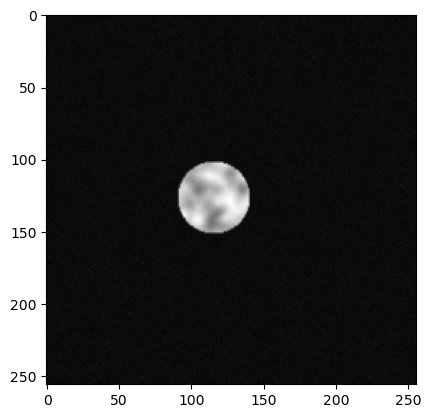

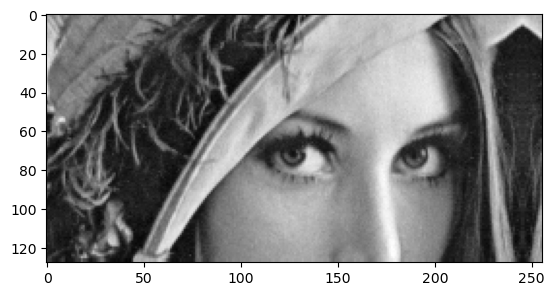

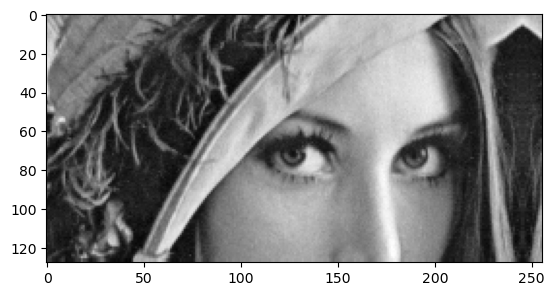

In [91]:
horiz_displacement = 10.
vert_displacement  = 1.
b = np.array([ horiz_displacement, vert_displacement])

# We could also use an affine motion matrix
#B = np.zeros((2,2))

im_ball_noisy_shifted = applyAffineMotion(im_ball_noisy,b)
plt.figure(),plt.imshow(im_ball_noisy_shifted,cmap='gray')

im_lena_noisy_shifted = applyAffineMotion(im_lena_noisy,b)
plt.figure(),plt.imshow(im_lena_noisy_shifted,cmap='gray')

im_lena_shifted = applyAffineMotion(im_lena_noisy,b)
plt.figure(),plt.imshow(im_lena_shifted,cmap='gray')

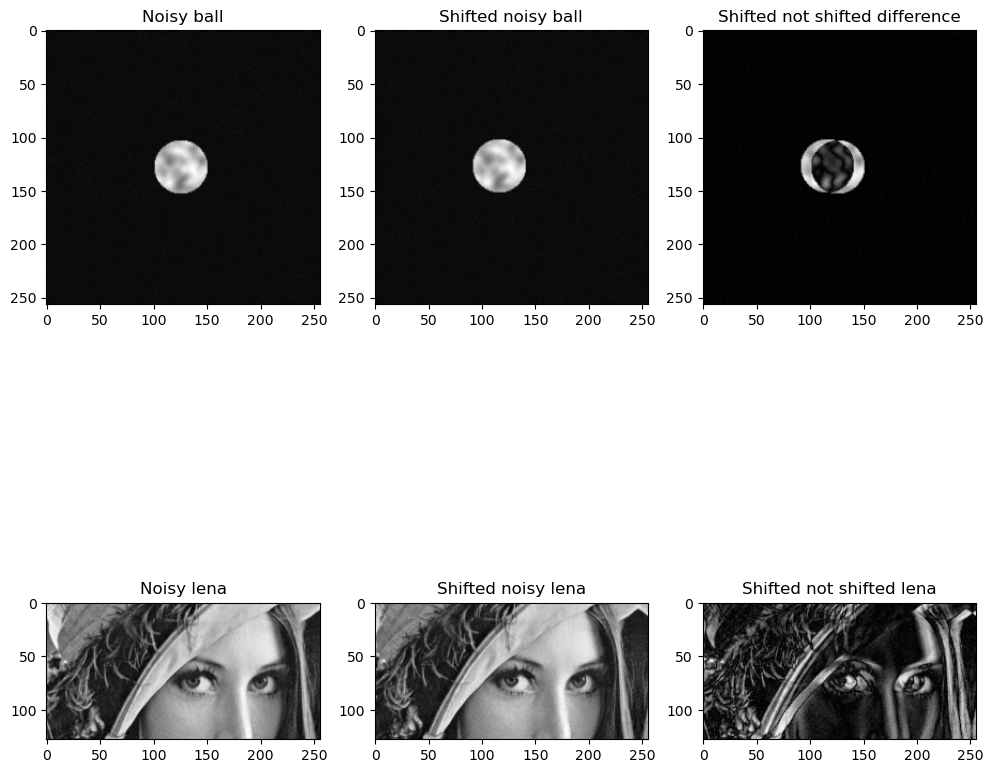

In [92]:
# plot the difference 
plt.figure(figsize=(12,12))
plt.subplot(2, 3, 1) 
plt.imshow(im_ball_noisy, cmap='gray')
plt.title('Noisy ball') 

plt.subplot(2, 3, 2)  
plt.imshow(im_ball_noisy_shifted, cmap='gray')  
plt.title('Shifted noisy ball') 

plt.subplot(2, 3, 3)  
plt.imshow(np.abs(im_ball_noisy_shifted-im_ball_noisy), cmap='gray')  
plt.title('Shifted not shifted difference')  

plt.subplot(2, 3, 4)  
plt.imshow(im_lena_noisy, cmap='gray')
plt.title('Noisy lena')  

plt.subplot(2, 3, 5) 
plt.imshow(im_lena_noisy_shifted, cmap='gray')  
plt.title('Shifted noisy lena')  
plt.subplot(2, 3, 6) 
plt.imshow(np.abs(im_lena_noisy-im_lena_noisy_shifted), cmap='gray')
plt.title('Shifted not shifted lena')  

plt.show() 


Compute the FFT of the two images. Using the indications given in the theroretical part, describe a method with which you can find the parameters of the translation from the two FFTs.

**Answer:**

In [93]:
IM1_ball_noisy = np.fft.fft2(im_ball_noisy)
IM2_shidted_ball_noisy = np.fft.fft2(im_ball_noisy_shifted)

IM1_lena_noisy = np.fft.fft2(im_lena_noisy)
IM2_shidted_lena_noisy = np.fft.fft2(im_lena_noisy_shifted)

IM1_lena = np.fft.fft2(im_lena)
IM1_lena_shifted = np.fft.fft2(im_lena_shifted)

Compute the phase of the Fourier transform.

In [94]:
def angle2D(x):
    a = np.angle(x)
    
    b1 = np.unwrap(a,axis=0)
    b2 = np.unwrap(b1,axis=1)
    b3 = np.unwrap(a,axis=0)[:,::-1]
    b4 = np.unwrap(b3,axis=1)[:,::-1]
    
    y = (b2+b4)/2./(-2.*np.pi)
    return y

In [95]:
phi_ball = angle2D(IM2_shidted_ball_noisy/IM1_ball_noisy)
phi_lena = angle2D(IM2_shidted_lena_noisy/IM1_lena_noisy)
phi_lena_without_noise = angle2D(IM1_lena_shifted/IM1_lena)

Display phi. Is it a linear plane and why?

**Answer:**

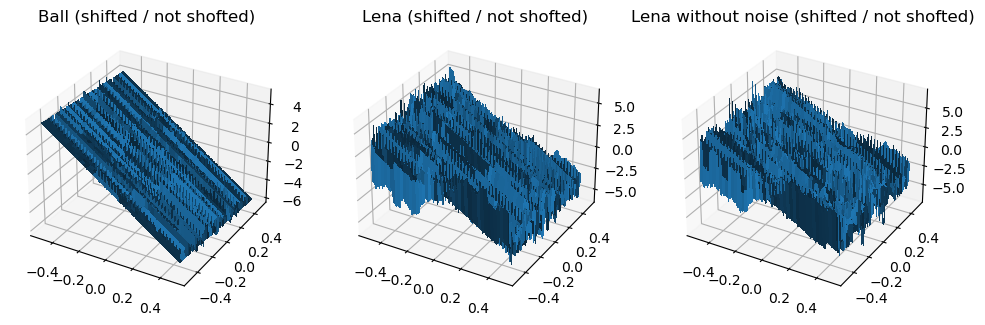

In [96]:
fx1, fy1 = np.meshgrid(np.arange(-(M_shape_ball-1)/2,(M_shape_ball-1)/2+1)/M_shape_ball, np.arange(-(N_shape_ball-1)/2,(N_shape_ball-1)/2+1)/N_shape_ball)

fx2, fy2 = np.meshgrid(np.arange(-(M_shape_lena-1)/2,(M_shape_lena-1)/2+1)/M_shape_lena, np.arange(-(N_shape_lena-1)/2,(N_shape_lena-1)/2+1)/N_shape_lena)

fx3, fy3 = np.meshgrid(np.arange(-(M_shape_lena-1)/2,(M_shape_lena-1)/2+1)/M_shape_lena, np.arange(-(N_shape_lena-1)/2,(N_shape_lena-1)/2+1)/N_shape_lena)

fig = plt.figure(figsize=(12, 10))

ax1 = fig.add_subplot(131, projection='3d')
surf1 = ax1.plot_surface(fx1, fy1, phi_ball, linewidth=0, antialiased=False)
ax1.set_title('Ball (shifted / not shofted)')

# Plot second mesh grid
ax2 = fig.add_subplot(132, projection='3d')
surf2 = ax2.plot_surface(fx2, fy2, phi_lena, linewidth=0, antialiased=False)
ax2.set_title('Lena (shifted / not shofted)')

ax3 = fig.add_subplot(133, projection='3d')
surf3 = ax3.plot_surface(fx3, fy3, phi_lena_without_noise, linewidth=0, antialiased=False)
ax3.set_title('Lena without noise (shifted / not shofted)')

plt.show()


When we look at the difference in angles ($\phi$) made by moving images and changing them into a special math form (FFT), we see different things based on the picture and how much noise (random dots) is there. for the case of the Ball where there is many uniform region, the meshgrid of the linear phase shift looks like a smooth, straight slope. This happens because moving the picture a little bit changes the angles in a predictable way, making it easy to spot this movement by looking at the slope.

But, when we add noise, like random noise with standard deviation of 2 as proposed by the lab, it's harder to see this smooth slope because the noise covers it up. Yet, we can still find the hidden slope that tells us about the movement by using special tricks to clean up the noise (we can use the proposed filter by the scipy,median filter gaussian,etc..).

On the other hand, for pictures without repeating patterns, like a person's photo, finding this slope is much harder. The picture's complex details make the angle differences messy and not straight, making it tough to figure out how the picture moved. This shows that our method works well for simple, repeating pictures, even with some noise, but not so well for complex pictures with lots of details.

Translation estimation: to estimate the parameters of the translation, we are now looking for the slope of the plane.

Method 1: estimate it using the median of the gradient. To do that, complete the gradient function.

In [97]:
def gradient(M,stepX=1.,stepY=1.):
# Computes the gradient of an image, over the rows and the column directions. StepY is the assumed gap between the rows and StepX is the assumed gap between the columns
    gy,gx = np.gradient(M,stepY)  
    return gx,gy

In [98]:
gx_ball, gy_ball = gradient(phi_ball,1/M_shape_ball,1/N_shape_ball)
GX_ball = np.median(gx_ball)
GY_ball = np.median(gy_ball)

gx_lena, gy_lena = gradient(phi_lena,1/M_shape_lena,1/N_shape_lena)
GX_lena = np.median(gx_lena)
GY_lena = np.median(gy_lena)


gx_lena_no_noise, gy_lena_no_noise = gradient(phi_lena_without_noise,1/M_shape_lena,1/N_shape_lena)
GX_lena_no_noise = np.median(gx_lena_no_noise)
GY_lena_no_noise = np.median(gy_lena_no_noise)

In [99]:
print(f'Noisy ball estimated displacement :{[GX_ball,GY_ball]}')
print(f'Noisy lena estimated displacement :{[GX_lena,GY_lena]}')
print(f'Lena estimated displacement :{[GX_lena_no_noise,GY_lena_no_noise]}')

Noisy ball estimated displacement :[-9.964527195544889, -1.0524210380415866]
Noisy lena estimated displacement :[-4.7953554183040055, -1.689299487351903]
Lena estimated displacement :[-4.500254830572215, 0.1686766635788448]


Method 2: the code below computes the least Square planar approximation of phi, enabling you how to estimate the parameters of the translation. Explain how it works.

In [119]:
def medianFilter(x,N):
    z = copyMakeBorder(x, N, N, N, N, BORDER_REPLICATE)
    y = np.zeros(np.shape(x))
    
    for r in range(np.shape(x)[0]):
        for c in range(np.shape(x)[1]):
            tmp = z[r:r+2*N+1,c:c+2*N+1]
            y[r,c] = np.median(tmp)
    return y



In [120]:
phi = phi_ball-phi_ball[int(N_shape_ball/2+2), int(M_shape_ball/2+2)]
t = medianFilter(phi,1)
A = np.zeros((np.shape(fx1)[0]*np.shape(fx1)[1],2))
A[:,0] = fx1.reshape(np.shape(fx1)[0]*np.shape(fx1)[1])
A[:,1] = fy1.reshape(np.shape(fy1)[0]*np.shape(fy1)[1])
b = t.reshape(np.shape(t)[0]*np.shape(t)[1])
bEst = np.dot(np.linalg.pinv(A),b)

In [121]:
print("the estimated displacement for Noisy Ball is ",bEst)

the estimated displacement for Noisy Ball is  [-9.64185988 -0.95426166]


In [122]:
phi = phi_lena-phi_lena[int(N_shape_lena/2+2), int(M_shape_lena/2+2)]
t = medianFilter(phi,1)
A = np.zeros((np.shape(fx2)[0]*np.shape(fx2)[1],2))
A[:,0] = fx2.reshape(np.shape(fx2)[0]*np.shape(fx2)[1])
A[:,1] = fy2.reshape(np.shape(fy2)[0]*np.shape(fy2)[1])
b = t.reshape(np.shape(t)[0]*np.shape(t)[1])
bEst = np.dot(np.linalg.pinv(A),b)

In [123]:
print("the estimated displacement for Noisy Lena is ",bEst)

the estimated displacement for Noisy Lena is  [-8.07852721  0.13641564]


In [105]:
phi = phi_lena_without_noise-phi_lena_without_noise[int(N_shape_lena/2+2), int(M_shape_lena/2+2)]
t = medianFilter(phi,1)
A = np.zeros((np.shape(fx3)[0]*np.shape(fx3)[1],2))
A[:,0] = fx3.reshape(np.shape(fx3)[0]*np.shape(fx3)[1])
A[:,1] = fy3.reshape(np.shape(fy3)[0]*np.shape(fy3)[1])
b = t.reshape(np.shape(t)[0]*np.shape(t)[1])
bEst = np.dot(np.linalg.pinv(A),b)

In [106]:
print("the estimated displacement for Lena is ",bEst)

the estimated displacement for Lena is  [-7.07790347  0.27261324]


Explication of the metod : 

1. Preprocessing with Median Filter:

The medianFilter function applies a median filter to the phase difference $map(\phi)$ to reduce noise. Median filtering is a non-linear process useful for preserving edges while removing noise. The function takes an input array x and a window size N, creating a padded version of x to handle edge cases and then applying the median filter over a window of size (2N+1),(2N+1) for each element.

2. Phase Difference Adjustment
The line:

phi = phi_ball - phi_ball[int(N_shape_ball/2+2), int(M_shape_ball/2+2)]

adjusts the phase difference map by subtracting a reference phase value located roughly at the center of the map. This adjustment aims to normalize the phase difference, making the subsequent analysis more robust to absolute phase offsets.

3. Least Squares Planar Approximation:

The core of the method involves fitting a plane to the phase difference $map (\phi)$ in a least squares sense. The idea is to model the phase difference map as a plane, where the plane's slope in the x and y directions corresponds to the translation between the images in those respective directions.

Gradient Arrays (fx1, fy1): These arrays contain the spatial frequencies corresponding to each pixel in the x and y directions. They act as the independent variables in the linear model.

Matrix A Construction: The matrix A is constructed by reshaping fx1 and fy1 into columns. Each row of A corresponds to a pair of spatial frequency components for a particular pixel in the phase map.

Vector b Construction: The vector b is formed by reshaping the filtered phase map t into a column vector. It represents the dependent variable in the linear model.

Least Squares Solution (bEst): The least squares solution is found by computing the pseudo-inverse of A and multiplying it by b. This operation estimates the best-fit plane coefficients, which correspond to the translation parameters.

4. Translation Parameters Estimation
The output bEst contains the estimated coefficients of the plane. These coefficients directly relate to the translation parameters:

bEst[0]: The coefficient corresponding to the spatial frequency in the x-direction. This value is proportional to the translation along the x-axis.

bEst[1]: The coefficient for the spatial frequency in the y-direction, proportional to the translation along the y-axis.

**Relaunch the above code**:
- with and without noise
- with the lena image, instead of the ball image.

Each time, are you able to correctly estimate the translation? Why? Comment your results.

Answer :

The least squares planar approximation method for estimating translation parameters shows varying effectiveness depending on image characteristics and noise levels. In the case of the ball image, which  has a more uniform and periodic structure where there are some uniform clear region it still uniform even if we added a noise, the method successfully estimates translation parameters, even in the presence of noise. The median filtering step is crucial here, as it significantly reduces noise impact and it is well-known that it preserves the edges and the main informations, allowing the underlying translation-induced phase shifts to be accurately captured. However, when applied to the Lena image,here we are in more complecated case where the regions are very detailed and there is more information to be preserved for example the complex textures and patterns, the method's performance drops. This inconsistency appears because the phase difference map of a complex image doesn't align as smartly with a simple planar model. The complicated or complex details and variaty of patterns in the Lena image introduce non-linear phase variations that challenge the method's basic assumption of consistent phase shifts due to translation. As a result, while effective for simpler, more periodic images, the method's reliability diminishes or destroys with increasing image complexity, insisting the need for tailored approaches or additional processing steps for complex scenes.

to insist on this answer we can see the vector of displacement of lena given by the method where we obtained a vector of [-7.99649953  0.1033208 ] for the noisy lena and [-6.68878768  0.21012911] for the none noisy lena.


# II-Indirect parametric estimation
In this last part, we will perform indirect parametric estimation. The movement vector field will be estimated by 1) block matching; 2) optic flow. **You have to reuse here the functions that you implemented during the first practical work**. Each time, you will then estimate the translation by taking the median of the estimated vector field.

Perform the experiment without and with noise (you can then take sigma = 2).

Finally, compare all the parametric estimation methods when the translation values are not integer.

the estimated displacement is respectively to the right and top [10.0, 1.0]


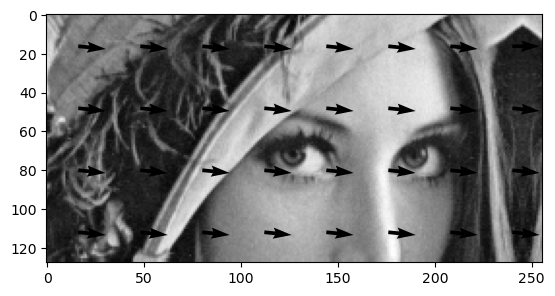

In [107]:
lamb = 0
mvf_lena,prediction_lena = me_ssd(im_lena_noisy_shifted,im_lena_noisy,32,32,10,lamb)
displayMVF(im_lena_noisy_shifted,mvf_lena,32)
mvf_x_lena = mvf_lena[:,:,1]
mvf_y_lena = mvf_lena[:,:,0]
bx_lena = np.median(mvf_x_lena)
by_lena = np.median(mvf_y_lena)
print(f'the estimated displacement is respectively to the right and top {[bx_lena,by_lena]}')

the estimated displacement is respectively to the right and top [10.0, 1.0]


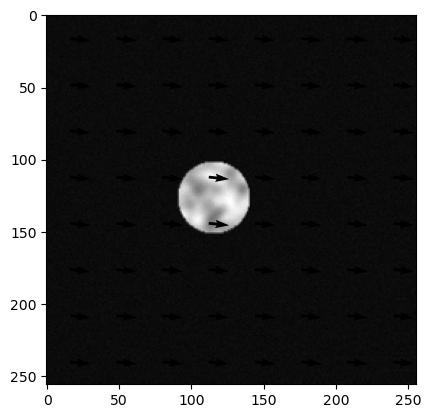

In [108]:
lamb = 0
mvf_ball,prediction_ball = me_ssd(im_ball_noisy_shifted,im_ball_noisy,32,32,10,lamb)
displayMVF(im_ball_noisy_shifted,mvf_ball,32)
mvf_x_ball = mvf_ball[:,:,1]
mvf_y_ball = mvf_ball[:,:,0]
bx_ball = np.median(mvf_x_ball)
by_ball = np.median(mvf_y_ball)
print(f'the estimated displacement is respectively to the right and top {[bx_ball,by_ball]}')

Estimation with optic flow

In [109]:
def computeDerivatives(im1, im2):
    kernel1D = np.expand_dims((1./12.)*np.array([-1., 8., 0., -8., 1.]),axis=1).T
    fx = convolve2d(im1,kernel1D,'same')
    fy = convolve2d(im1,kernel1D.T,'same')
    ft = convolve2d(im1, 0.25*np.ones((2,2)),'same') + convolve2d(im2, -0.25*np.ones((2,2)),'same');
    fx =-fx;
    fy=-fy;

    return fx, fy, ft


#%%
def HS(im1, im2, uInitial, vInitial, alpha=1, ite=100,blur = 1.):
    """
    Horn-Schunck optical flow method.
    Horn, B.K.P., and Schunck, B.G., Determining Optical Flow, AI(17), No. 1-3, August 1981, pp. 185-203 http://dspace.mit.edu/handle/1721.1/6337
    
    [u, v] = HS(im1, im2, alpha, ite, uInitial, vInitial, displayFlow)
    
    Parameters
    ----------
    im1, im2 : np.array
        Two subsequent frames or images.
    uInitial, vInitial: np.array
        Initial values for the (u,v) flow. If well initialized, the flow would converge faster and hence would need less iterations.
    alpha : scalar
        A parameter that reflects the influence of the smoothness term.
    ite : int
        Number of iterations.

    Returns
    -------
    u,v : np.array
        Optical flow.
    """
    
    im1 = gaussian_filter(im1,blur)
    im2 = gaussian_filter(im2,blur)
    
    # Set initial value for the flow vectors
    u = uInitial.copy()
    v = vInitial.copy()
    
    # Estimate spatiotemporal derivatives
    fx, fy, ft = computeDerivatives(im1, im2)
    
    # Averaging kernel
    kernel_1=np.array([[1./12., 1./6., 1./12.],[1./6., 0., 1./6.],[1./12., 1./6., 1./12.]])
    
    for i in range(ite):
        # Compute local averages of the flow vectors using kernel_1
        uAvg=convolve2d(u,kernel_1,'same')
        vAvg=convolve2d(v,kernel_1,'same')
        # now we need to compute the laplacian of f
        kernel_lap = np.array([[0,1,0],[1,-4,1],[0,1,0]])
        lap_f = convolve2d(im1,kernel_lap,'same')
        # Compute flow vectors constrained by its local average and the optical flow constraints
        u = u - fx*((uAvg*fx+vAvg*fy+ft)/(alpha**2 + np.linalg.norm(lap_f)**2))
        v = v - fy*((uAvg*fx+vAvg*fy+ft)/(alpha**2 + np.linalg.norm(lap_f)**2))
        
    # since there is a risk to obtain a NAN not a number in the matrix so to avoid that we can do the following codes   
    u[np.isnan(u)]= 0
    v[np.isnan(v)]= 0
    return u, v

9.999829689827235
0.9999900744093897


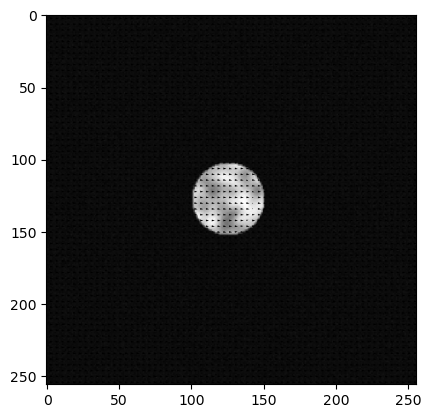

In [110]:
alpha = 100
ite = 100
uInitial = mvf_ball[:,:,1]
vInitial = mvf_ball[:,:,0]

u, v = HS(im_ball_noisy_shifted, im_ball_noisy, uInitial, vInitial, alpha, ite)
mvf_hs = np.zeros((np.shape(v)[0],np.shape(v)[1],2))
mvf_hs[:,:,0] = v
mvf_hs[:,:,1] = u
displayMVF(im_ball_noisy,mvf_hs,4)
bx = np.median(u)
by = np.median(v)
print(bx)
print(by)

9.999500554430963
0.9999622901034054


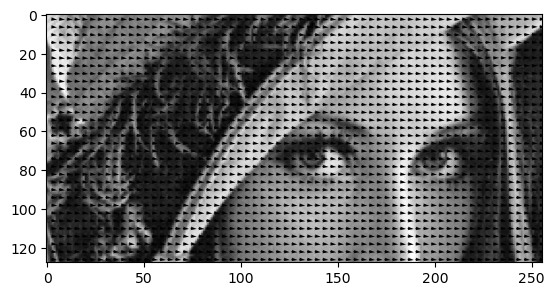

In [111]:
alpha = 100
ite = 100
uInitial = mvf_lena[:,:,1]
vInitial = mvf_lena[:,:,0]

u, v = HS(im_lena_noisy_shifted, im_lena_noisy, uInitial, vInitial, alpha, ite)
mvf_hs = np.zeros((np.shape(v)[0],np.shape(v)[1],2))
mvf_hs[:,:,0] = v
mvf_hs[:,:,1] = u
displayMVF(im_lena_noisy,mvf_hs,4)
bx = np.median(u)
by = np.median(v)
print(bx)
print(by)

Intrepretation :

Indirect parametric estimation via block matching and optic flow is depend on notecibale texture and detail within the image for accurate motion detection. Uniform areas, like the black background of the ball image, offer limited features for these methods to track, often leading to inaccurate motion estimates. Essentially, these methods misinterpret motion when prominent features are absent or the background is too uniform.

In contrast, with Lena's image, rich in textures and details, block matching performs well due to the abundance of distinct features that facilitate accurate block comparisons across frames. However, optic flow may encounter difficulties with complex textures, as its assumptions of motion smoothness might not align with the variability present in Lena's image. This can result in performance discrepancies, highlighting optic flow's sensitivity to specific motion types and image complexity.



(<Figure size 640x480 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x1e28481c6d0>)

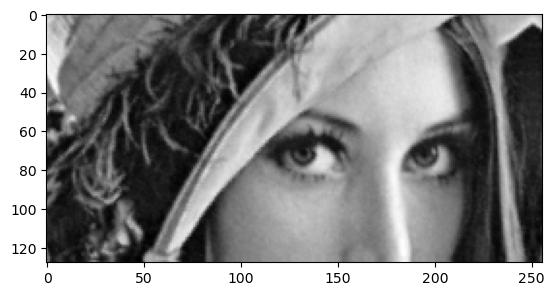

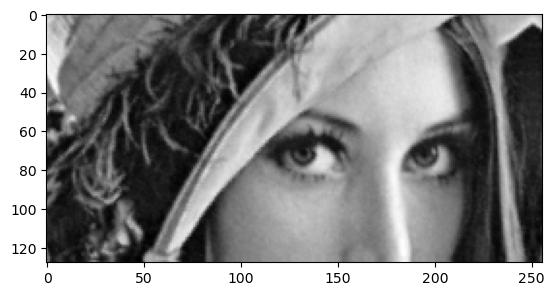

In [112]:
horiz_displacement = 4.6
vert_displacement  = 1.6
b = np.array([ horiz_displacement, vert_displacement])

# We could also use an affine motion matrix
#B = np.zeros((2,2))

im_lena_noisy_shifted_float = applyAffineMotion(im_lena_noisy,b)
plt.figure(),plt.imshow(im_lena_noisy_shifted_float,cmap='gray')

im_lena_shifted_float = applyAffineMotion(im_lena_noisy,b)
plt.figure(),plt.imshow(im_lena_shifted_float,cmap='gray')

the estimated displacement is respectively to the right and top [5.0, 2.0]


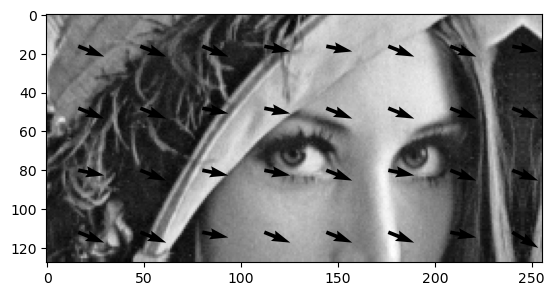

In [113]:
lamb = 0
mvf_lena_float,prediction_ball = me_ssd(im_lena_noisy_shifted_float,im_lena_noisy,32,32,10,lamb)
displayMVF(im_lena_noisy_shifted,mvf_lena_float,32)
mvf_x_lena_float = mvf_lena_float[:,:,1]
mvf_y_lena_float = mvf_lena_float[:,:,0]
bx_lena_f_v = np.median(mvf_x_lena_float)
by_lena_f_v = np.median(mvf_y_lena_float)
print(f'the estimated displacement is respectively to the right and top {[bx_lena_f_v,by_lena_f_v]}')

the estimated displacement is respectively to the right and top [5.0, 2.0]


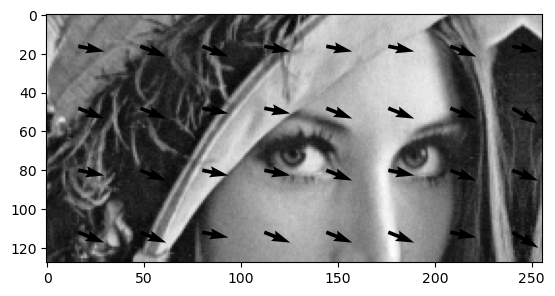

In [114]:
lamb = 0
mvf_lena_float_without_noise,prediction_ball = me_ssd(im_lena_shifted_float,im_lena,32,32,10,lamb)
displayMVF(im_lena_shifted,mvf_lena_float_without_noise,32)
mvf_x_lena_float = mvf_lena_float_without_noise[:,:,1]
mvf_y_lena_float = mvf_lena_float_without_noise[:,:,0]
bx_lena_f_v = np.median(mvf_x_lena_float)
by_lena_f_v = np.median(mvf_y_lena_float)
print(f'the estimated displacement is respectively to the right and top {[bx_lena_f_v,by_lena_f_v]}')

the estimated displacement is respectively to the right and top [4.999820724323088, 1.9986743446927948]


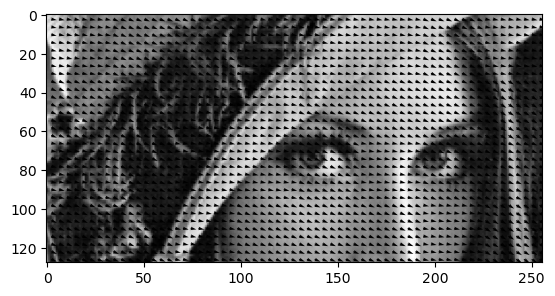

In [115]:
alpha = 100
ite = 100
uInitial = mvf_lena_float_without_noise[:,:,1]
vInitial = mvf_lena_float_without_noise[:,:,0]

u, v = HS(im_lena_shifted, im_lena, uInitial, vInitial, alpha, ite)
mvf_hs = np.zeros((np.shape(v)[0],np.shape(v)[1],2))
mvf_hs[:,:,0] = v
mvf_hs[:,:,1] = u
displayMVF(im_lena,mvf_hs,4)
bx = np.median(u)
by = np.median(v)
print(f'the estimated displacement is respectively to the right and top {[bx,by]}')

the estimated displacement is respectively to the right and top [4.999818898938786, 1.9994606886349904]


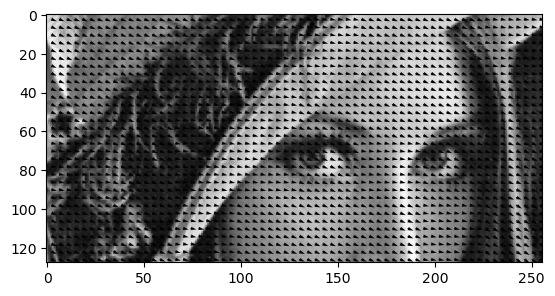

In [116]:
alpha = 100
ite = 100
uInitial = mvf_lena_float[:,:,1]
vInitial = mvf_lena_float[:,:,0]

u, v = HS(im_lena_noisy_shifted, im_lena_noisy, uInitial, vInitial, alpha, ite)
mvf_hs = np.zeros((np.shape(v)[0],np.shape(v)[1],2))
mvf_hs[:,:,0] = v
mvf_hs[:,:,1] = u
displayMVF(im_lena_noisy,mvf_hs,4)
bx = np.median(u)
by = np.median(v)
print(f'the estimated displacement is respectively to the right and top {[bx,by]}')

Intrepreting the results :

When we try to figure out how much an image has moved using numbers that are not integer in our example we took [4.6,1.6], both block matching and optical flow methods find it tricky in both cases with or without noise i tested the methods on lena image.

Block Matching: This method usually works by looking at whole pixels. So if an image moves a bit less than a whole pixel, block matching might not catch that tiny movement. It rounds the movement to the nearest  number, which is good for a rough guess but not perfect for movements that are in between pixels.

Optical Flow: This method is better at noticing these small, in-between movements because it looks at how the brightness of pixels changes, which can show movement that is less than a whole pixel. For the noisy ball image, optical flow did a good job guessing these small moves (the use case or the example not provided but i tested it). But for Lena's image ,which is the intersting case, has a lots of different textures and details, optical flow didn't do as well.This is due to the presence of details and finner information.

In simple words, block matching is good for whole pixel moves but not great for smaller, precise moves. Optical flow is more sensitive and can pick up on these smaller moves, but it might get confused with complex images that have lots of details and textures(example of lena).